# Simple Autoencoder Model

*This is my submission for Google Code-in's Tensorflow Autoencoder challenge.*

This notebook walks you through how to create a simple autoencoder using Keras that can encode and decode images in the MNIST dataset. Enjoy :)

Author: Adar Kahiri

In [1]:
#Importing dependencies
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Reshape, Conv2DTranspose
import matplotlib.pyplot as plt 
import numpy as np
print(tf.__version__)

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


2.0.0


## Importing & Normalizing The Data

In [2]:
train, test = tf.keras.datasets.mnist.load_data(path='mnist.npz')

train_images, _ = train #It's not necessary to keep the labels for autoencoders
test_images, _ = test

#Normalizing images to between 0 and 1. Dividing by 255 (the max brightness of a pixel) ensures this. 
train_images, test_images = np.divide(train_images, 255), np.divide(test_images, 255)

## Visualizing A Batch Of Data

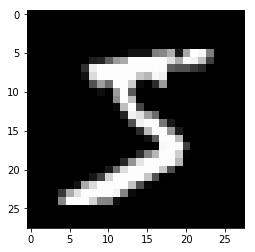

In [3]:
fig = plt.figure()
plt.imshow(train_images[0], cmap='gray') #Printing the first training image

In [4]:
#Converting the data from numpy arrays to TensorFlow tensors
train_images = tf.convert_to_tensor(train_images)
test_images = tf.convert_to_tensor(test_images)

print("Training shape: {} \nOutput shape: {}".format(train_images.shape, test_images.shape))

Training shape: (60000, 28, 28) 
Output shape: (10000, 28, 28)


## Creating the encoder and decoder

In [5]:
# ------------- ENCODER ------------- #
encoder = Sequential() #Initializing the encoder
encoder.add(Conv2D(16, kernel_size=2, input_shape=(28, 28, 1), padding='same', strides=2, activation='relu' )) #16 filters, 2x2 kernels, stride of 2, and ReLu activation function. 
encoder.add(Conv2D(24, kernel_size=2, padding='same', strides=2, activation='relu')) #24 filters, 2x2 kernels, stride of 2, and ReLu activation function. 
encoder.add(Flatten()) #Flattening the image so it can be put through a dense layer
encoder.add(Dense(32, input_shape=(7*7*24,), activation='relu')) #Input shape is obtained from the dimensions of each image multiplied by # of convolutional layers beforehand.


# ------------- ENCODER ------------- #
'''
This is basically the reverse of the encoder. It will take the input generated by the final linear (dense)
of the encoder, and convert it back to its original form. If it can do this well, we'll know that the embedding
generated by the encoder was accurate. 
'''
decoder = Sequential() #Initializing the decoder
decoder.add(Dense(7*7*24, input_shape=(32,), activation='relu'))
decoder.add(Reshape((7, 7, 24)))
decoder.add(Conv2DTranspose(16, kernel_size=2, padding='same', strides=2, activation='relu'))
decoder.add(Conv2DTranspose(1, kernel_size=2, padding='same', strides=2, activation='relu'))

#Output a 'model summary'. This is useful for debugging since it shows us the shape of the output at each step. 
encoder.summary()
decoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 16)        80        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 24)          1560      
_________________________________________________________________
flatten (Flatten)            (None, 1176)              0         
_________________________________________________________________
dense (Dense)                (None, 32)                37664     
Total params: 39,304
Trainable params: 39,304
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1176)              38808     
______________________________

## Creating the composite model (the complete autoencoder)
Right now we have two separate models. In order to train them as one model, we can use the Functional API. 

In [6]:
#Creating the model graph
img_input = Input(shape=(28, 28, 1))
encoder_output = encoder(img_input) #Feeding image input into encoder model
decoder_output = decoder(encoder_output) #Feeding the encoder output into the decoder model

#Defining the model
autoencoder = Model(inputs=img_input, outputs=decoder_output) #
autoencoder.summary() #Display the shape of the output.

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
sequential (Sequential)      (None, 32)                39304     
_________________________________________________________________
sequential_1 (Sequential)    (None, 28, 28, 1)         40425     
Total params: 79,729
Trainable params: 79,729
Non-trainable params: 0
_________________________________________________________________


## Training the model

In [7]:
#Adding a channel dimension of 1 to input
train_images = tf.expand_dims(train_images, -1)
test_images = tf.expand_dims(test_images, -1)
print(train_images.shape)
print(test_images.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [8]:
#Specifying hyperparamaters
n_epochs = 30 #Number of epochs over which the model will train 

#Specifying loss function, metrics, and optimizer
loss = tf.keras.losses.BinaryCrossentropy() #Using mean squared error loss
metrics = tf.metrics.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Adam() #Using the Adam Optimizer


#Compiling the model
autoencoder.compile(optimizer=optimizer, loss=loss, metrics=[metrics])

#Running the model
history = autoencoder.fit(train_images, train_images, epochs=16)

Train on 60000 samples
Epoch 1/16
60000/60000 [==============================] - 15s 246us/sample - loss: 0.1848 - binary_crossentropy: 0.1848
Epoch 2/16
60000/60000 [==============================] - 13s 224us/sample - loss: 0.1499 - binary_crossentropy: 0.1499
Epoch 3/16
60000/60000 [==============================] - 13s 224us/sample - loss: 0.1372 - binary_crossentropy: 0.1372
Epoch 4/16
60000/60000 [==============================] - 14s 227us/sample - loss: 0.1343 - binary_crossentropy: 0.1343
Epoch 5/16
60000/60000 [==============================] - 14s 229us/sample - loss: 0.1360 - binary_crossentropy: 0.1360
Epoch 6/16
60000/60000 [==============================] - 14s 230us/sample - loss: 0.1288 - binary_crossentropy: 0.1288
Epoch 7/16
60000/60000 [==============================] - 15s 246us/sample - loss: 0.1265 - binary_crossentropy: 0.1265
Epoch 8/16
60000/60000 [==============================] - 14s 237us/sample - loss: 0.1316 - binary_crossentropy: 0.1316
Epoch 9/16
60000/

## Visualizing the output

Enter the index of the image in the test set you'd like to test: 0


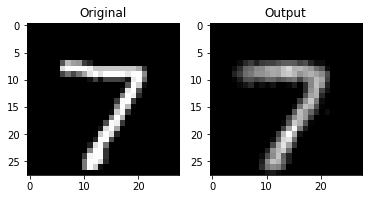

In [9]:
idx = int(input("Enter the index of the image in the test set you'd like to test: "))
test_image = tf.expand_dims(test_images[idx], 0)
new_image = autoencoder.predict(test_image)

fig = plt.figure()

original = fig.add_subplot(1, 2, 1)
original.imshow(test_images[idx].numpy().squeeze(), cmap='gray')
original.set_title('Original')

output = fig.add_subplot(1, 2, 2)
output.imshow(new_image.squeeze(), cmap='gray') 
output.set_title('Output')
plt.show()
